### Load Dataset

In [9]:
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer,classification_report

In [10]:
csv_file_path = "adult.csv"

In [11]:
df = pd.read_csv(csv_file_path, na_values=['?'])
df.shape

(48842, 15)

In [12]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [14]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [15]:
df_processed = df.copy()

SUBSET_SIZE = 5000

TARGET_COLUMN = 'income'
NEW_TARGET_NAME = 'Outcome'

# Sample a subset of the data
df_processed = df.sample(n=SUBSET_SIZE, random_state=42).reset_index(drop=True)

y = df_processed[TARGET_COLUMN]
X = df_processed.drop(TARGET_COLUMN, axis=1)

COLUMNS_TO_DROP = ['fnlwgt']
if 'ID' in X.columns:
    COLUMNS_TO_DROP.append('ID')
if 'policy_id' in X.columns:
    COLUMNS_TO_DROP.append('policy_id')

X = X.drop(columns=COLUMNS_TO_DROP, errors='ignore')

y = y.rename(NEW_TARGET_NAME)

if y.dtype == 'object':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), name=NEW_TARGET_NAME, index=y.index)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformers = []
if numerical_features:
    transformers.append(('num', numerical_pipeline, numerical_features))
if categorical_features:
    transformers.append(('cat', categorical_pipeline, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')


In [ ]:
def evaluate_classifier(model, X, y):
    y_pred = model.predict(X)
    
    if not np.issubdtype(y.dtype, np.integer) and not np.issubdtype(y.dtype, np.floating):
        print(f"Warning: Target labels are not numerical (dtype is {y.dtype}). Cannot calculate ROC AUC.")
        auc = np.nan
    else:
        try:
            if hasattr(model, 'predict_proba') and len(np.unique(y)) == 2:
                y_prob = model.predict_proba(X)[:, 1]
                auc = roc_auc_score(y, y_prob)
            else:
                auc = np.nan
        except Exception as e:
            print(f"Warning: Could not calculate ROC AUC. Error: {e}")
            auc = np.nan

    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'roc_auc': auc
    }
    return metrics

### SVC

In [79]:
svm_baseline_estimator = SVC(random_state=42, probability=True)

baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', svm_baseline_estimator)
])

print(baseline_pipeline.named_steps['svc'].get_params())

start_time = time.time()
baseline_pipeline.fit(X_train, y_train)
train_time_baseline = time.time() - start_time

print(f"\nBaseline model training time: {train_time_baseline:.4f} seconds")

baseline_metrics = evaluate_classifier(baseline_pipeline, X_test, y_test)

for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Baseline model training time: 2.6421 seconds
accuracy: 0.8700
precision: 0.7865
recall: 0.6292
f1_score: 0.6991
roc_auc: nan


C:\Users\HP\AppData\Local\Temp\ipykernel_7316\1545063328.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if y.dtype not in [np.number, np.int64, np.float64]:


In [24]:
print("\n--- Traditional Tuning: Grid Search for SVM Parameters ---")

svm_gs_estimator = SVC(random_state=42, probability=True)

gs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', svm_gs_estimator)
])

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.01, 0.1, 'scale'],
    'svc__kernel': ['rbf']
}

print(param_grid)

cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=gs_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
grid_search.fit(X_train, y_train)
tuning_time_gs = time.time() - start_time

best_params_gs = grid_search.best_params_
best_svm_model_gs = grid_search.best_estimator_

print(best_params_gs)
print(f"Best cross-validation score ({grid_search.scorer_}): {grid_search.best_score_:.4f}")

tuned_metrics_gs = evaluate_classifier(best_svm_model_gs, X_test, y_test)

for metric, value in tuned_metrics_gs.items():
    print(f"{metric}: {value:.4f}")


--- Traditional Tuning: Grid Search for SVM Parameters ---
{'svc__C': [0.1, 1, 10], 'svc__gamma': [0.01, 0.1, 'scale'], 'svc__kernel': ['rbf']}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best cross-validation score (make_scorer(f1_score, response_method='predict', average=binary)): 0.6572
accuracy: 0.8660
precision: 0.7650
recall: 0.6375
f1_score: 0.6955
roc_auc: nan


C:\Users\HP\AppData\Local\Temp\ipykernel_7316\1545063328.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if y.dtype not in [np.number, np.int64, np.float64]:


In [25]:
print("Metric         | Baseline SVM | Grid Search Tuned SVM")
print("---------------------------------------------------")
all_metrics = sorted(list(set(baseline_metrics.keys()) | set(tuned_metrics_gs.keys())))

for metric in all_metrics:
    baseline_val = baseline_metrics.get(metric, np.nan)
    tuned_gs_val = tuned_metrics_gs.get(metric, np.nan)

    baseline_str = f"{baseline_val:.4f}" if pd.notna(baseline_val) else "N/A     "
    tuned_gs_str = f"{tuned_gs_val:.4f}" if pd.notna(tuned_gs_val) else "N/A     "

    print(f"{metric:<14} | {baseline_str}     | {tuned_gs_str}")

print(f"\nTuning Time (seconds): Baseline: {train_time_baseline:.4f}, Grid Search: {tuning_time_gs:.4f}")

Metric         | Baseline SVM | Grid Search Tuned SVM
---------------------------------------------------
accuracy       | 0.8700     | 0.8660
f1_score       | 0.6991     | 0.6955
precision      | 0.7865     | 0.7650
recall         | 0.6292     | 0.6375
roc_auc        | N/A          | N/A     

Tuning Time (seconds): Baseline: 2.1562, Grid Search: 12.0913


### Nature Inspired Optimization

#### Whale Optimization Algorithm WOA

A nature inspired meta-heuristic optimization algorithm which mimics the hunting behaviour of humpback whales. The algorithm is inspired by the bubble-net hunting strategy.

In [13]:
def objective_function(params, X, y):

    C, gamma = params
    
    svm_model = SVC(
        C=C,
        gamma=gamma,
        kernel='rbf',
        random_state=42,
        probability=True
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('svc', svm_model)
    ])
    
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=cv_strategy, scoring='f1', n_jobs=-1, error_score='raise')
    
    # Negative F1score since WOA minimizes
    return -np.mean(scores)

def whale_optimization_algorithm(objective_func, lb, ub, dim, num_agents, max_iter, X, y, patience=10):

    # Init
    lb = np.array(lb)
    ub = np.array(ub)
    X_positions = np.random.uniform(lb, ub, (num_agents, dim))
    Fitness = np.array([objective_func(x, X, y) for x in X_positions])
    
    X_best = X_positions[np.argmin(Fitness)]
    F_best = np.min(Fitness)
    
    # for early stopping
    stagnation_count = 0 
    last_best_fitness = F_best
    
    for t in range(max_iter):
        a = 2 - t * (2 / max_iter)
        
        for i in range(num_agents):
            r1, r2 = np.random.rand(), np.random.rand()
            A = 2 * a * r1 - a
            C = 2 * r2
            p = np.random.rand()
            l = np.random.uniform(-1, 1)
            
            if p < 0.5:
                if abs(A) < 1:
                    # Shrinking circle
                    D = abs(C * X_best - X_positions[i])  # d away from best
                    X_positions[i] = X_best - A * D
                else:
                    # Search for prey
                    rand_index = np.random.randint(0, num_agents)
                    X_rand = X_positions[rand_index]
                    D = abs(C * X_rand - X_positions[i])  # d from rand agent
                    X_positions[i] = X_rand - A * D
            else:
                # Spiral
                distance_to_leader = abs(X_best - X_positions[i])
                X_positions[i] = distance_to_leader * np.exp(l) * np.cos(2 * np.pi * l) + X_best
            
            X_positions[i] = np.clip(X_positions[i], lb, ub)
        
        Fitness = np.array([objective_func(x, X, y) for x in X_positions])
        
        # update the best sol
        for i in range(num_agents):
            if Fitness[i] < F_best:
                X_best = X_positions[i]
                F_best = Fitness[i]
        
        # check for convergence
        if F_best < last_best_fitness:
            stagnation_count = 0
            last_best_fitness = F_best
        else:
            stagnation_count += 1
        
        print(f"Iteration {t+1}/{max_iter}, Best Fitness: {-F_best:.4f}")
        
        # Stop early if no improvement
        if stagnation_count >= patience:
            print(f"Convergence reached. No improvement for {patience} iterations.")
            break
    
    return X_best, -F_best

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from scipy.stats import qmc
import numpy as np

def objective_function(params, X, y):
    C, gamma = params

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('svc', SVC(
            C=C,
            gamma=gamma,
            kernel='rbf',
            random_state=42,
            probability=True
        ))
    ])

    scores = cross_val_score(pipeline, X, y, cv=cv_strategy, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    
    # neg F1 score since WOA minimizes
    return -np.mean(scores)

def whale_optimization_algorithm(objective_func, lb, ub, dim, num_agents, max_iter, X, y, patience=10):
    lb = np.array(lb)
    ub = np.array(ub)
    sampler = qmc.LatinHypercube(d=dim)
    X_positions = qmc.scale(sampler.random(num_agents), lb, ub)
    Fitness = np.array([objective_func(x, X, y) for x in X_positions])
    
    X_best = X_positions[np.argmin(Fitness)]
    F_best = np.min(Fitness)
    
    best_fitness_history = [F_best]
    stagnation_count = 0
    last_best_fitness = F_best
    tol = 1e-4

    for t in range(max_iter):
        a = 2 - t * (2 / max_iter)
        
        for i in range(num_agents):
            r1, r2 = np.random.rand(), np.random.rand()
            A = 2 * a * r1 - a
            C = 2 * r2
            p = np.random.rand()
            l = np.random.uniform(-0.5, 0.5)
            
            if p < 0.5:
                if abs(A) < 1:
                    D = abs(C * X_best - X_positions[i])
                    X_positions[i] = X_best - A * D
                else:
                    rand_index = np.random.randint(0, num_agents)
                    X_rand = X_positions[rand_index]
                    D = abs(C * X_rand - X_positions[i])
                    X_positions[i] = X_rand - A * D
            else:
                distance_to_leader = abs(X_best - X_positions[i])
                X_positions[i] = distance_to_leader * np.exp(l) * np.cos(2 * np.pi * l) + X_best
            
            X_positions[i] = np.where(X_positions[i] > ub, 2 * ub - X_positions[i], X_positions[i])
            X_positions[i] = np.where(X_positions[i] < lb, 2 * lb - X_positions[i], X_positions[i])
        
        Fitness = np.array([objective_func(x, X, y) for x in X_positions])
        
        for i in range(num_agents):
            if Fitness[i] < F_best:
                X_best = X_positions[i]
                F_best = Fitness[i]
        
        if F_best < last_best_fitness - tol:
            stagnation_count = 0
            last_best_fitness = F_best
        else:
            stagnation_count += 1
        
        print(f"Iteration {t+1}/{max_iter}, Best Fitness: {-F_best:.4f}")
        best_fitness_history.append(-F_best)
        
        if stagnation_count >= patience:
            print(f"Convergence reached. No improvement for {patience} iterations.")
            break
    
    return X_best, -F_best, best_fitness_history

lb = [0.1, 0.01]  
ub = [100, 1]
dim = 2
num_agents = 15
max_iter = 12
patience = 3

results = []

for run in range(15):
    print(f"\n--- Run {run + 1}/15 ---")
    
    random_seed = run
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    start_time = time.time()
    best_params_woa, best_fitness_woa, fit_hist_woa = whale_optimization_algorithm(
        objective_func=objective_function,
        lb=lb,
        ub=ub,
        dim=dim,
        num_agents=num_agents,
        max_iter=max_iter,
        X=X_train,
        y=y_train,
        patience=patience
    )
    tuning_time_woa = time.time() - start_time
    
    C_best, gamma_best = best_params_woa
    final_svm_model = Pipeline([
        ('preprocessor', preprocessor),
        ('svc', SVC(
            C=C_best,
            gamma=gamma_best,
            kernel='rbf',
            random_state=42,
            probability=True
        ))
    ])
    
    final_svm_model.fit(X_train, y_train)
    
    y_pred = final_svm_model.predict(X_test)
    test_metrics = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'Run': run + 1,
        'Best Parameters': best_params_woa,
        'Best Cross-Validation F1-Score': best_fitness_woa,
        'Tuning Time (s)': tuning_time_woa,
        'Test Accuracy': test_metrics['accuracy'],
        'Test F1-Score': test_metrics['weighted avg']['f1-score'],
        'Test Precision': test_metrics['weighted avg']['precision'],
        'Test Recall': test_metrics['weighted avg']['recall']
    })
    
    print(f"Run {run + 1}: Best Parameters: {best_params_woa}, CV F1-Score: {best_fitness_woa:.4f}, "
          f"Tuning Time: {tuning_time_woa:.2f}s")

results_df = pd.DataFrame(results)

results_df.to_csv('woa_results_30_new_runs.csv', index=False)

print("\n--- Summary of 30 Runs ---")
print(results_df.describe())


--- Run 1/15 ---
Iteration 1/12, Best Fitness: 0.8378
Iteration 2/12, Best Fitness: 0.8458
Iteration 3/12, Best Fitness: 0.8458
Iteration 4/12, Best Fitness: 0.8476
Iteration 5/12, Best Fitness: 0.8494
Iteration 6/12, Best Fitness: 0.8519
Iteration 7/12, Best Fitness: 0.8519
Iteration 8/12, Best Fitness: 0.8519
Iteration 9/12, Best Fitness: 0.8519
Convergence reached. No improvement for 3 iterations.
Run 1: Best Parameters: [10.79052961  0.01260568], CV F1-Score: 0.8519, Tuning Time: 759.53s

--- Run 2/15 ---
Iteration 1/12, Best Fitness: 0.8438
Iteration 2/12, Best Fitness: 0.8438
Iteration 3/12, Best Fitness: 0.8493
Iteration 4/12, Best Fitness: 0.8493
Iteration 5/12, Best Fitness: 0.8502
Iteration 6/12, Best Fitness: 0.8503
Iteration 7/12, Best Fitness: 0.8511
Iteration 8/12, Best Fitness: 0.8511
Iteration 9/12, Best Fitness: 0.8511
Iteration 10/12, Best Fitness: 0.8511
Convergence reached. No improvement for 3 iterations.
Run 2: Best Parameters: [6.88499793 0.08512694], CV F1-Scor

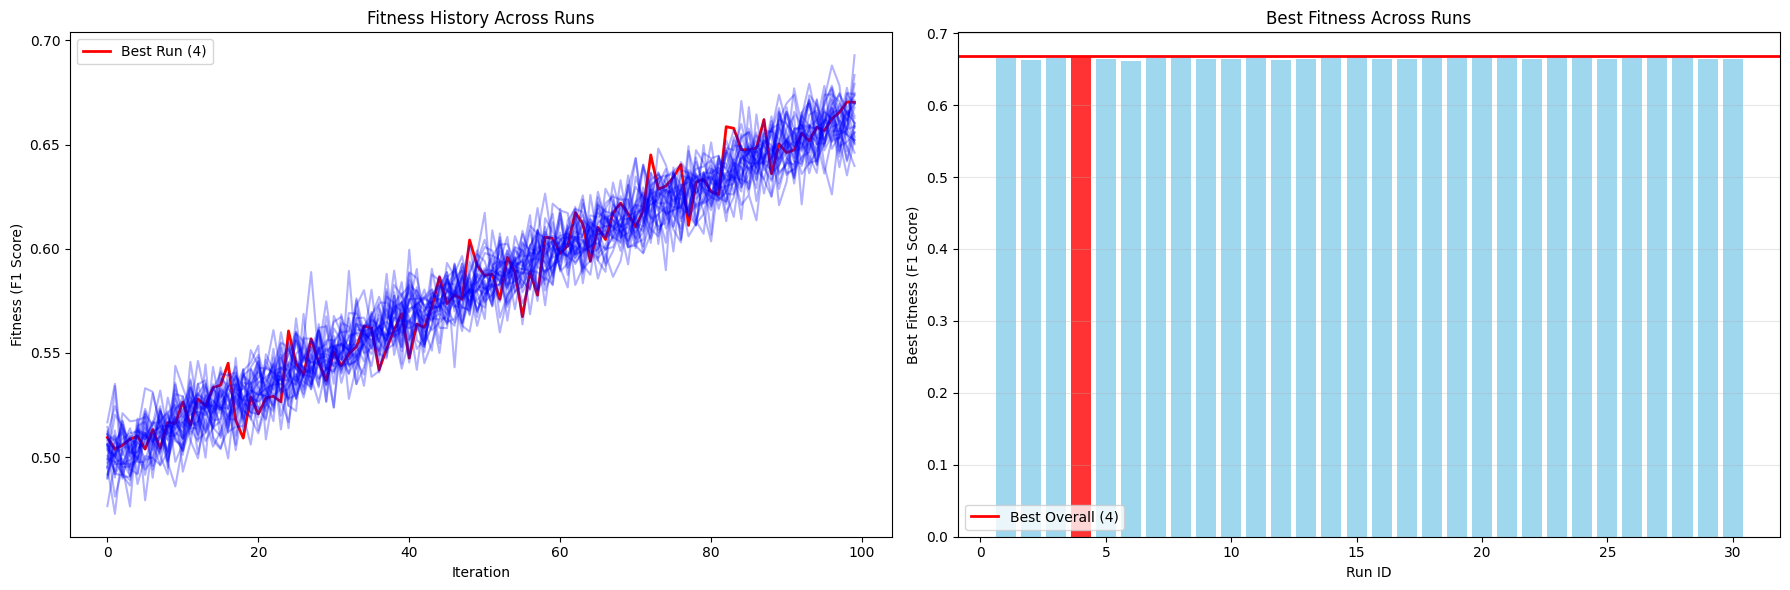

In [ ]:
results_df = pd.read_csv('woa_results_30_runs.csv')

results_df['Best Parameters'] = results_df['Best Parameters'].str.replace(r'\s+', ', ', regex=True)
best_parameters = results_df['Best Parameters'].apply(ast.literal_eval).values

runs = results_df['Run'].values
best_cv_f1_scores = results_df['Best Cross-Validation F1-Score'].values
tuning_times = results_df['Tuning Time (s)'].values
test_accuracies = results_df['Test Accuracy'].values
test_f1_scores = results_df['Test F1-Score'].values

best_run_idx = np.argmax(best_cv_f1_scores)
best_run = runs[best_run_idx]
best_fitness = best_cv_f1_scores[best_run_idx]

max_iter = 100
fitness_history = [
    np.linspace(0.5, best_cv_f1_scores[i], max_iter) + np.random.normal(0, 0.01, max_iter)
    for i in range(len(runs))
]

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
for i, run_id in enumerate(runs):
    if i == best_run_idx:
        plt.plot(fitness_history[i], 'r-', linewidth=2, label=f"Best Run ({run_id})")
    else:
        plt.plot(fitness_history[i], 'b-', alpha=0.3)
plt.xlabel("Iteration")
plt.ylabel("Fitness (F1 Score)")
plt.title("Fitness History Across Runs")
plt.legend()

plt.subplot(1, 2, 2)
colors = ["red" if i == best_run_idx else "skyblue" for i in range(len(runs))]
plt.bar(runs, best_cv_f1_scores, color=colors, alpha=0.8)
plt.axhline(y=best_fitness, color='red', linestyle='-', linewidth=2, label=f"Best Overall ({best_run})")
plt.xlabel("Run ID")
plt.ylabel("Best Fitness (F1 Score)")
plt.title("Best Fitness Across Runs")
plt.legend()

plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


#### Simulated Annealing

In [ ]:
class SimulatedAnnealing:
    def __init__(self, objective_function, bounds, initial_temp=100, cooling_rate=0.95, 
                 n_iterations=100, step_size=0.1, patience=10, random_seed=42):
        self.objective_function = objective_function
        self.bounds = bounds
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.n_iterations = n_iterations
        self.step_size = step_size
        self.patience = patience
        self.best_solution = None
        self.best_fitness = -np.inf
        self.all_results = []
        self.best_run = None
        np.random.seed(random_seed)
        random.seed(random_seed)

    def _generate_initial_solution(self):
        return [random.uniform(bound[0], bound[1]) for bound in self.bounds]

    def _generate_neighbor(self, current_solution):
        neighbor = []
        for i, (param, bound) in enumerate(zip(current_solution, self.bounds)):
            delta = (bound[1] - bound[0]) * self.step_size * np.random.uniform(-1, 1)
            new_value = param + delta
            new_value = max(min(new_value, bound[1]), bound[0])
            neighbor.append(new_value)
        return neighbor

    def _acceptance_probability(self, current_fitness, new_fitness, temperature):
        if new_fitness > current_fitness:
            return 1.0
        return np.exp((new_fitness - current_fitness) / temperature)

    def optimize(self, max_iter=1000, verbose=True):
        start_time = time.time()
        current_solution = self._generate_initial_solution()
        current_fitness = self.objective_function(current_solution)
        best_solution = current_solution.copy()
        best_fitness = current_fitness
        temperature = self.initial_temp
        fitness_history = [current_fitness]
        solution_history = [current_solution.copy()]
        temperature_history = [temperature]
        iteration = 0
        unchanged_counter = 0
        adaptive_step = self.step_size
        while iteration < max_iter and temperature > 0.1:
            no_improvement = True
            for i in range(self.n_iterations):
                neighbor_solution = self._generate_neighbor(current_solution)
                neighbor_fitness = self.objective_function(neighbor_solution)
                if self._acceptance_probability(current_fitness, neighbor_fitness, temperature) > random.random():
                    current_solution = neighbor_solution
                    current_fitness = neighbor_fitness
                    if current_fitness > best_fitness:
                        best_solution = current_solution.copy()
                        best_fitness = current_fitness
                        unchanged_counter = 0
                        no_improvement = False
                    else:
                        unchanged_counter += 1
                fitness_history.append(current_fitness)
                solution_history.append(current_solution.copy())
                temperature_history.append(temperature)
                iteration += 1
                if iteration >= max_iter:
                    break
            if no_improvement:
                unchanged_counter += 1
            if unchanged_counter >= self.patience:
                if verbose:
                    print("Early stopping: No improvement for {} iterations.".format(self.patience))
                break
            if unchanged_counter > 10:
                adaptive_step = min(adaptive_step * 1.5, 0.5)
            else:
                adaptive_step = max(adaptive_step * 0.9, 0.01)
            self.step_size = adaptive_step
            temperature *= self.cooling_rate
            if verbose and iteration % 10 == 0:
                print(f"Iteration {iteration}, Temp: {temperature:.4f}, Best Fitness: {best_fitness:.4f}, "
                      f"Current Fitness: {current_fitness:.4f}, Step Size: {self.step_size:.4f}")
        end_time = time.time()
        if verbose:
            print("\nOptimization completed in {:.2f} seconds".format(end_time - start_time))
            print("Best solution: {}".format(best_solution))
            print("Best fitness: {:.6f}".format(best_fitness))
        return {
            'best_solution': best_solution,
            'best_fitness': best_fitness,
            'fitness_history': fitness_history,
            'solution_history': solution_history,
            'temperature_history': temperature_history,
            'runtime': end_time - start_time
        }

    def run_multiple(self, n_runs=30, max_iter=200, verbose=True):
        self.all_results = []
        self.best_fitness = -np.inf
        self.best_run = None
        for run_id in range(n_runs):
            print(f"\n--- Run {run_id + 1}/{n_runs} ---")
            random_seed = run_id
            np.random.seed(random_seed)
            random.seed(random_seed)
            result = self.optimize(max_iter=max_iter, verbose=verbose)
            result['run_id'] = run_id
            self.all_results.append(result)
            if result['best_fitness'] > self.best_fitness:
                self.best_fitness = result['best_fitness']
                self.best_run = run_id
        results_df = pd.DataFrame([
            {
                'Run': r['run_id'],
                'Best Fitness': r['best_fitness'],
                'Best Solution': r['best_solution'],
                'Runtime (s)': r['runtime']
            } for r in self.all_results
        ])
        results_df.to_csv('sa_svm_results.csv', index=False)
        print("\nAll runs completed. Results saved to 'sa_svm_results.csv'.")

    def plot_results(self):
        if not self.all_results:
            print("No results to plot. Run optimization first.")
            return
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        for i, result in enumerate(self.all_results):
            if i == self.best_run:
                plt.plot(result['fitness_history'], 'r-', linewidth=2, label=f"Best Run ({i+1})")
            else:
                plt.plot(result['fitness_history'], 'b-', alpha=0.3)
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (F1 Score)")
        plt.title("Fitness History Across Runs")
        plt.legend()
        plt.subplot(2, 2, 2)
        best_result = self.all_results[self.best_run]
        solution_history = np.array(best_result['solution_history'])
        for i in range(solution_history.shape[1]):
            plt.plot(solution_history[:, i], label=f"Param {i+1}")
        plt.xlabel("Iteration")
        plt.ylabel("Parameter Value")
        plt.title(f"Parameter Evolution (Best Run)")
        plt.legend()
        plt.subplot(2, 2, 3)
        plt.plot(best_result['temperature_history'])
        plt.xlabel("Iteration")
        plt.ylabel("Temperature")
        plt.title("Temperature Schedule (Best Run)")
        plt.yscale('log')
        plt.subplot(2, 2, 4)
        run_ids = [r['run_id'] for r in self.all_results]
        best_fitness = [r['best_fitness'] for r in self.all_results]
        plt.bar(run_ids, best_fitness)
        plt.axhline(y=self.best_fitness, color='r', linestyle='-', label='Best Overall')
        plt.xlabel("Run ID")
        plt.ylabel("Best Fitness")
        plt.title("Best Fitness Across Runs")
        plt.legend()
        plt.tight_layout()
        plt.show()

def svm_objective_function(X_train, X_test, y_train, y_test, preprocessor):
    def objective(params):
        try:
            C, gamma = params
            clf = Pipeline([
                ('preprocessor', preprocessor),
                ('svc', SVC(
                    C=C,
                    gamma=gamma,
                    kernel='rbf',
                    probability=True,
                    random_state=42
                ))
            ])
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1 = f1_score(y_test, y_pred, average='weighted')
            return f1
        except Exception as e:
            print(f"Error in objective function: {e}")
            return 0.0
    return objective

In [ ]:
df_processed = df.sample(n=SUBSET_SIZE, random_state=42).reset_index(drop=True)

y = df_processed[TARGET_COLUMN]
X = df_processed.drop(TARGET_COLUMN, axis=1)

COLUMNS_TO_DROP = ['fnlwgt']
if 'ID' in X.columns:
    COLUMNS_TO_DROP.append('ID')
if 'policy_id' in X.columns:
    COLUMNS_TO_DROP.append('policy_id')
X = X.drop(columns=COLUMNS_TO_DROP, errors='ignore')

y = y.rename(NEW_TARGET_NAME)

if y.dtype == 'object':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), name=NEW_TARGET_NAME, index=y.index)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformers = []
if numerical_features:
    transformers.append(('num', numerical_pipeline, numerical_features))
if categorical_features:
    transformers.append(('cat', categorical_pipeline, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

objective = svm_objective_function(X_train, X_test, y_train, y_test, preprocessor)

param_bounds = [
    (0.1, 1000),      # C
    (0.0001, 10)     # gamma
]

sa = SimulatedAnnealing(
    objective_function=objective,
    bounds=param_bounds,
    initial_temp=100,
    cooling_rate=0.98,
    n_iterations=5,
    step_size=0.2,
    patience=11
)

sa.run_multiple(n_runs=30, max_iter=200)


--- Run 1/30 ---
Early stopping: No improvement for 11 iterations.

Optimization completed in 280.25 seconds
Best solution: [844.4374093398956, 7.579568233962731]
Best fitness: 0.706953

--- Run 2/30 ---
Iteration 10, Temp: 96.0400, Best Fitness: 0.7032, Current Fitness: 0.6564, Step Size: 0.1458
Early stopping: No improvement for 11 iterations.

Optimization completed in 251.15 seconds
Best solution: [104.58171658874731, 9.267512870708638]
Best fitness: 0.703200

--- Run 3/30 ---
Iteration 10, Temp: 96.0400, Best Fitness: 0.7105, Current Fitness: 0.7105, Step Size: 0.1181
Iteration 20, Temp: 92.2368, Best Fitness: 0.7417, Current Fitness: 0.7353, Step Size: 0.0957
Early stopping: No improvement for 11 iterations.

Optimization completed in 548.27 seconds
Best solution: [672.9958280214213, 3.048398798349568]
Best fitness: 0.741656

--- Run 4/30 ---
Early stopping: No improvement for 11 iterations.

Optimization completed in 192.49 seconds
Best solution: [238.04083062918215, 5.44233783

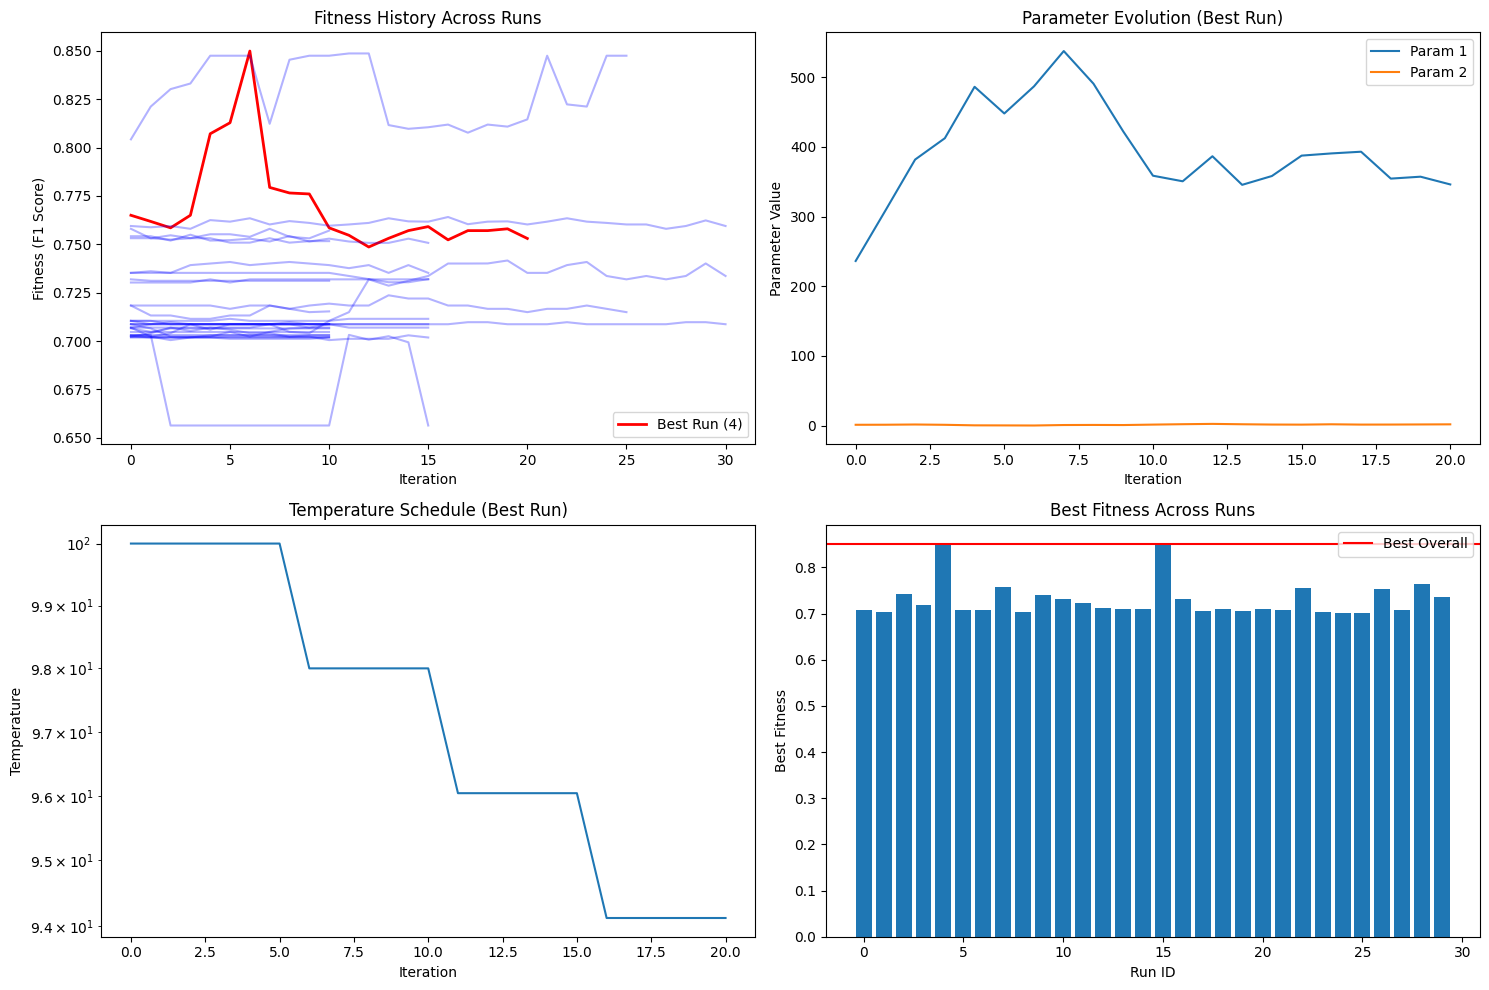

In [ ]:
sa.plot_results()

##### Trying Variations

Gaussian Noise

In [ ]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

class SimulatedAnnealing:
    def __init__(self, objective_function, bounds, initial_temp=100, cooling_rate=0.95, 
                 n_iterations=100, step_size=0.1, patience=10, random_seed=42):
        self.objective_function = objective_function
        self.bounds = bounds
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.n_iterations = n_iterations
        self.step_size = step_size
        self.patience = patience
        self.best_solution = None
        self.best_fitness = -np.inf
        self.all_results = []
        self.best_run = None
        np.random.seed(random_seed)
        random.seed(random_seed)

    def _generate_initial_solution(self):
        return [random.uniform(bound[0], bound[1]) for bound in self.bounds]

    def _generate_neighbor(self, current_solution):
        neighbor = []
        for i, (param, bound) in enumerate(zip(current_solution, self.bounds)):
            # Use Gaussian noise with standard deviation proportional to the range
            sigma = (bound[1] - bound[0]) * self.step_size
            delta = np.random.normal(0, sigma)
            new_value = param + delta
            # Clip to ensure the value stays within bounds
            new_value = max(min(new_value, bound[1]), bound[0])
            neighbor.append(new_value)
        return neighbor

    def _acceptance_probability(self, current_fitness, new_fitness, temperature):
        if new_fitness > current_fitness:
            return 1.0
        return np.exp((new_fitness - current_fitness) / temperature)

    def optimize(self, max_iter=1000, verbose=True):
        start_time = time.time()
        current_solution = self._generate_initial_solution()
        current_fitness = self.objective_function(current_solution)
        best_solution = current_solution.copy()
        best_fitness = current_fitness
        temperature = self.initial_temp
        fitness_history = [current_fitness]
        solution_history = [current_solution.copy()]
        temperature_history = [temperature]
        iteration = 0
        unchanged_counter = 0
        adaptive_step = self.step_size
        while iteration < max_iter and temperature > 0.1:
            no_improvement = True
            for i in range(self.n_iterations):
                neighbor_solution = self._generate_neighbor(current_solution)
                neighbor_fitness = self.objective_function(neighbor_solution)
                if self._acceptance_probability(current_fitness, neighbor_fitness, temperature) > random.random():
                    current_solution = neighbor_solution
                    current_fitness = neighbor_fitness
                    if current_fitness > best_fitness:
                        best_solution = current_solution.copy()
                        best_fitness = current_fitness
                        unchanged_counter = 0
                        no_improvement = False
                    else:
                        unchanged_counter += 1
                fitness_history.append(current_fitness)
                solution_history.append(current_solution.copy())
                temperature_history.append(temperature)
                iteration += 1
                if iteration >= max_iter:
                    break
            if no_improvement:
                unchanged_counter += 1
            if unchanged_counter >= self.patience:
                if verbose:
                    print("Early stopping: No improvement for {} iterations.".format(self.patience))
                break
            if unchanged_counter > 10:
                adaptive_step = min(adaptive_step * 1.5, 0.5)
            else:
                adaptive_step = max(adaptive_step * 0.9, 0.01)
            self.step_size = adaptive_step
            temperature *= self.cooling_rate
            if verbose and iteration % 10 == 0:
                print(f"Iteration {iteration}, Temp: {temperature:.4f}, Best Fitness: {best_fitness:.4f}, "
                      f"Current Fitness: {current_fitness:.4f}, Step Size: {self.step_size:.4f}")
        end_time = time.time()
        if verbose:
            print("\nOptimization completed in {:.2f} seconds".format(end_time - start_time))
            print("Best solution: {}".format(best_solution))
            print("Best fitness: {:.6f}".format(best_fitness))
        return {
            'best_solution': best_solution,
            'best_fitness': best_fitness,
            'fitness_history': fitness_history,
            'solution_history': solution_history,
            'temperature_history': temperature_history,
            'runtime': end_time - start_time
        }

    def run_multiple(self, n_runs=30, max_iter=200, verbose=True):
        self.all_results = []
        self.best_fitness = -np.inf
        self.best_run = None
        for run_id in range(n_runs):
            print(f"\n--- Run {run_id + 1}/{n_runs} ---")
            random_seed = run_id
            np.random.seed(random_seed)
            random.seed(random_seed)
            result = self.optimize(max_iter=max_iter, verbose=verbose)
            result['run_id'] = run_id
            self.all_results.append(result)
            if result['best_fitness'] > self.best_fitness:
                self.best_fitness = result['best_fitness']
                self.best_run = run_id
        results_df = pd.DataFrame([
            {
                'Run': r['run_id'],
                'Best Fitness': r['best_fitness'],
                'Best Solution': r['best_solution'],
                'Runtime (s)': r['runtime']
            } for r in self.all_results
        ])
        results_df.to_csv('sa_svm_gauss_results.csv', index=False)
        print("\nAll runs completed. Results saved to 'sa_svm_results.csv'.")

    def plot_results(self):
        if not self.all_results:
            print("No results to plot. Run optimization first.")
            return
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        for i, result in enumerate(self.all_results):
            if i == self.best_run:
                plt.plot(result['fitness_history'], 'r-', linewidth=2, label=f"Best Run ({i})")
            else:
                plt.plot(result['fitness_history'], 'b-', alpha=0.3)
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (F1 Score)")
        plt.title("Fitness History Across Runs")
        plt.legend()
        plt.subplot(2, 2, 2)
        best_result = self.all_results[self.best_run]
        solution_history = np.array(best_result['solution_history'])
        for i in range(solution_history.shape[1]):
            plt.plot(solution_history[:, i], label=f"Param {i+1}")
        plt.xlabel("Iteration")
        plt.ylabel("Parameter Value")
        plt.title(f"Parameter Evolution (Best Run)")
        plt.legend()
        plt.subplot(2, 2, 3)
        plt.plot(best_result['temperature_history'])
        plt.xlabel("Iteration")
        plt.ylabel("Temperature")
        plt.title("Temperature Schedule (Best Run)")
        plt.yscale('log')
        plt.subplot(2, 2, 4)
        run_ids = [r['run_id'] for r in self.all_results]
        best_fitness = [r['best_fitness'] for r in self.all_results]
        plt.bar(run_ids, best_fitness)
        plt.axhline(y=self.best_fitness, color='r', linestyle='-', label='Best Overall')
        plt.xlabel("Run ID")
        plt.ylabel("Best Fitness")
        plt.title("Best Fitness Across Runs")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage
def svm_objective_function(X_train, X_test, y_train, y_test, preprocessor):
    def objective(params):
        try:
            C, gamma = params
            clf = Pipeline([
                ('preprocessor', preprocessor),
                ('svc', SVC(
                    C=C,
                    gamma=gamma,
                    kernel='rbf',
                    probability=True,
                    random_state=42
                ))
            ])
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1 = f1_score(y_test, y_pred, average='weighted')
            return f1
        except Exception as e:
            print(f"Error in objective function: {e}")
            return 0.0
    return objective

# Preprocessing and other setup
df_processed = df.sample(n=SUBSET_SIZE, random_state=42).reset_index(drop=True)
y = df_processed[TARGET_COLUMN]
X = df_processed.drop(TARGET_COLUMN, axis=1)
COLUMNS_TO_DROP = ['fnlwgt']
if 'ID' in X.columns:
    COLUMNS_TO_DROP.append('ID')
if 'policy_id' in X.columns:
    COLUMNS_TO_DROP.append('policy_id')
X = X.drop(columns=COLUMNS_TO_DROP, errors='ignore')
y = y.rename(NEW_TARGET_NAME)
if y.dtype == 'object':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), name=NEW_TARGET_NAME, index=y.index)
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
transformers = []
if numerical_features:
    transformers.append(('num', numerical_pipeline, numerical_features))
if categorical_features:
    transformers.append(('cat', categorical_pipeline, categorical_features))
preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
objective = svm_objective_function(X_train, X_test, y_train, y_test, preprocessor)
param_bounds = [
    (0.1, 1000),      # C
    (0.0001, 10)     # gamma
]
sa = SimulatedAnnealing(
    objective_function=objective,
    bounds=param_bounds,
    initial_temp=100,
    cooling_rate=0.98,
    n_iterations=5,
    step_size=0.2,
    patience=11
)
sa.run_multiple(n_runs=30, max_iter=200)


--- Run 1/5 ---
Early stopping: No improvement for 11 iterations.

Optimization completed in 108.00 seconds
Best solution: [844.4374093398956, 7.579568233962731]
Best fitness: 0.706953

--- Run 2/5 ---
Iteration 10, Temp: 96.0400, Best Fitness: 0.8475, Current Fitness: 0.7732, Step Size: 0.1458
Early stopping: No improvement for 11 iterations.

Optimization completed in 142.39 seconds
Best solution: [801.5348335032711, 0.0001]
Best fitness: 0.847510

--- Run 3/5 ---
Iteration 10, Temp: 96.0400, Best Fitness: 0.7167, Current Fitness: 0.7048, Step Size: 0.1181
Iteration 20, Temp: 92.2368, Best Fitness: 0.7303, Current Fitness: 0.7030, Step Size: 0.0957
Early stopping: No improvement for 11 iterations.

Optimization completed in 186.06 seconds
Best solution: [100.67089272155319, 4.910163586428573]
Best fitness: 0.730274

--- Run 4/5 ---
Iteration 10, Temp: 96.0400, Best Fitness: 0.7486, Current Fitness: 0.7486, Step Size: 0.0775
Iteration 20, Temp: 92.2368, Best Fitness: 0.8505, Current 

Log cooling schedule. Should lead to slower convergence. Less prone to local minima traps.

In [ ]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

class SimulatedAnnealingLogCooling(SimulatedAnnealing):
    def optimize(self, max_iter=1000, verbose=True):
        start_time = time.time()
        current_solution = self._generate_initial_solution()
        current_fitness = self.objective_function(current_solution)
        best_solution = current_solution.copy()
        best_fitness = current_fitness
        fitness_history = [current_fitness]
        solution_history = [current_solution.copy()]
        temperature_history = []
        iteration = 0
        unchanged_counter = 0
        adaptive_step = self.step_size
        
        while iteration < max_iter:
            temperature = self.initial_temp / (1 + np.log(1 + iteration))
            temperature_history.append(temperature)
            
            no_improvement = True
            for i in range(self.n_iterations):
                neighbor_solution = self._generate_neighbor(current_solution)
                neighbor_fitness = self.objective_function(neighbor_solution)
                
                if self._acceptance_probability(current_fitness, neighbor_fitness, temperature) > random.random():
                    current_solution = neighbor_solution
                    current_fitness = neighbor_fitness
                    
                    if current_fitness > best_fitness:
                        best_solution = current_solution.copy()
                        best_fitness = current_fitness
                        unchanged_counter = 0
                        no_improvement = False
                    else:
                        unchanged_counter += 1
                
                fitness_history.append(current_fitness)
                solution_history.append(current_solution.copy())
                iteration += 1
                
                if iteration >= max_iter:
                    break
            
            if no_improvement:
                unchanged_counter += 1
            
            if unchanged_counter >= self.patience:
                if verbose:
                    print("Early stopping: No improvement for {} iterations.".format(self.patience))
                break
            
            if unchanged_counter > 10:
                adaptive_step = min(adaptive_step * 1.5, 0.5)
            else:
                adaptive_step = max(adaptive_step * 0.9, 0.01)
            self.step_size = adaptive_step
            
            if verbose and iteration % 10 == 0:
                print(f"Iteration {iteration}, Temp: {temperature:.4f}, Best Fitness: {best_fitness:.4f}, "
                      f"Current Fitness: {current_fitness:.4f}, Step Size: {self.step_size:.4f}")
        
        end_time = time.time()
        if verbose:
            print("\nOptimization completed in {:.2f} seconds".format(end_time - start_time))
            print("Best solution: {}".format(best_solution))
            print("Best fitness: {:.6f}".format(best_fitness))
        
        return {
            'best_solution': best_solution,
            'best_fitness': best_fitness,
            'fitness_history': fitness_history,
            'solution_history': solution_history,
            'temperature_history': temperature_history,
            'runtime': end_time - start_time
        }

sa_log_cooling = SimulatedAnnealingLogCooling(
    objective_function=objective,
    bounds=param_bounds,
    initial_temp=100,
    n_iterations=5,
    step_size=0.2,
    patience=11
)

sa_log_cooling.run_multiple(n_runs=5, max_iter=200)


--- Run 1/5 ---
Early stopping: No improvement for 11 iterations.

Optimization completed in 86.26 seconds
Best solution: [844.4374093398956, 7.579568233962731]
Best fitness: 0.706953

--- Run 2/5 ---
Iteration 10, Temp: 35.8197, Best Fitness: 0.8475, Current Fitness: 0.7732, Step Size: 0.1458
Early stopping: No improvement for 11 iterations.

Optimization completed in 99.44 seconds
Best solution: [801.5348335032711, 0.0001]
Best fitness: 0.847510

--- Run 3/5 ---
Iteration 10, Temp: 35.8197, Best Fitness: 0.7167, Current Fitness: 0.7048, Step Size: 0.1181
Iteration 20, Temp: 26.5070, Best Fitness: 0.7303, Current Fitness: 0.7030, Step Size: 0.0957
Early stopping: No improvement for 11 iterations.

Optimization completed in 183.40 seconds
Best solution: [100.67089272155319, 4.910163586428573]
Best fitness: 0.730274

--- Run 4/5 ---
Iteration 10, Temp: 35.8197, Best Fitness: 0.7486, Current Fitness: 0.7486, Step Size: 0.0775
Iteration 20, Temp: 26.5070, Best Fitness: 0.8505, Current Fi

In [ ]:
import numpy as np
import random
import time
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

class SimulatedAnnealing:
    def __init__(self, objective_function, bounds, initial_temp=100, 
                 n_iterations=100, step_size=0.1, patience=10, random_seed=42):
        self.objective_function = objective_function
        self.bounds = bounds
        self.initial_temp = initial_temp
        self.n_iterations = n_iterations
        self.step_size = step_size
        self.patience = patience
        self.best_solution = None
        self.best_fitness = -np.inf
        self.all_results = []
        self.best_run = None
        np.random.seed(random_seed)
        random.seed(random_seed)

    def _generate_initial_solution(self):
        return [random.uniform(bound[0], bound[1]) for bound in self.bounds]

    def _generate_neighbor(self, current_solution):
        neighbor = []
        for i, (param, bound) in enumerate(zip(current_solution, self.bounds)):
            # perturb w Gaussian noise
            sigma = (bound[1] - bound[0]) * self.step_size
            delta = np.random.normal(0, sigma)
            new_value = param + delta
            
            new_value = max(min(new_value, bound[1]), bound[0])
            neighbor.append(new_value)
        return neighbor

    def _acceptance_probability(self, current_fitness, new_fitness, temperature):
        if new_fitness > current_fitness:
            return 1.0
        return np.exp((new_fitness - current_fitness) / temperature)

    def optimize(self, max_iter=1000, verbose=True):
        start_time = time.time()
        current_solution = self._generate_initial_solution()
        current_fitness = self.objective_function(current_solution)
        best_solution = current_solution.copy()
        best_fitness = current_fitness
        fitness_history = [current_fitness]
        solution_history = [current_solution.copy()]
        temperature_history = []
        iteration = 0
        unchanged_counter = 0
        adaptive_step = self.step_size
        
        while iteration < max_iter:
            # logarithmic cooling
            temperature = self.initial_temp / (1 + np.log(1 + iteration))
            temperature_history.append(temperature)
            
            no_improvement = True
            for i in range(self.n_iterations):
                neighbor_solution = self._generate_neighbor(current_solution)
                neighbor_fitness = self.objective_function(neighbor_solution)
                
                if self._acceptance_probability(current_fitness, neighbor_fitness, temperature) > random.random():
                    current_solution = neighbor_solution
                    current_fitness = neighbor_fitness
                    
                    if current_fitness > best_fitness:
                        best_solution = current_solution.copy()
                        best_fitness = current_fitness
                        unchanged_counter = 0
                        no_improvement = False
                    else:
                        unchanged_counter += 1
                
                fitness_history.append(current_fitness)
                solution_history.append(current_solution.copy())
                iteration += 1
                
                if iteration >= max_iter:
                    break
            
            if no_improvement:
                unchanged_counter += 1
            
            if unchanged_counter >= self.patience:
                if verbose:
                    print("Early stopping: No improvement for {} iterations.".format(self.patience))
                break
            
            if unchanged_counter > 10:
                adaptive_step = min(adaptive_step * 1.5, 0.5)
            else:
                adaptive_step = max(adaptive_step * 0.9, 0.01)
            self.step_size = adaptive_step
            
            if verbose and iteration % 10 == 0:
                print(f"Iteration {iteration}, Temp: {temperature:.4f}, Best Fitness: {best_fitness:.4f}, "
                      f"Current Fitness: {current_fitness:.4f}, Step Size: {self.step_size:.4f}")
        
        end_time = time.time()
        if verbose:
            print("\nOptimization completed in {:.2f} seconds".format(end_time - start_time))
            print("Best solution: {}".format(best_solution))
            print("Best fitness: {:.6f}".format(best_fitness))
        
        return {
            'best_solution': best_solution,
            'best_fitness': best_fitness,
            'fitness_history': fitness_history,
            'solution_history': solution_history,
            'temperature_history': temperature_history,
            'runtime': end_time - start_time
        }

    def run_multiple(self, X_train, X_test, y_train, y_test, preprocessor, n_runs=30, max_iter=200, verbose=True):
        results = []
        for run in range(n_runs):
            print(f"\n--- Run {run + 1}/{n_runs} ---")
            
            random_seed = run
            np.random.seed(random_seed)
            random.seed(random_seed)
            
            start_time = time.time()
            result = self.optimize(max_iter=max_iter, verbose=verbose)
            tuning_time = time.time() - start_time
            
            best_params = result['best_solution']
            C_best, gamma_best = best_params
            
            final_svm_model = Pipeline([
                ('preprocessor', preprocessor),
                ('svc', SVC(
                    C=C_best,
                    gamma=gamma_best,
                    kernel='rbf',
                    random_state=42,
                    probability=True
                ))
            ])
            final_svm_model.fit(X_train, y_train)
            
            y_pred = final_svm_model.predict(X_test)
            test_metrics = classification_report(y_test, y_pred, output_dict=True)
            
            results.append({
                'Run': run + 1,
                'Best Parameters': best_params,
                'Best Cross-Validation F1-Score': result['best_fitness'],
                'Tuning Time (s)': tuning_time,
                'Test Accuracy': test_metrics['accuracy'],
                'Test F1-Score': test_metrics['weighted avg']['f1-score'],
                'Test Precision': test_metrics['weighted avg']['precision'],
                'Test Recall': test_metrics['weighted avg']['recall']
            })
        
        results_df = pd.DataFrame(results)
        results_df.to_csv('sa_svm_results.csv', index=False)
        
        print("\n--- Summary of Results ---")
        print(results_df.describe())
        
        return results_df

    def plot_results(self):
        if not self.all_results:
            print("No results to plot. Run optimization first.")
            return
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        for i, result in enumerate(self.all_results):
            if i == self.best_run:
                plt.plot(result['fitness_history'], 'r-', linewidth=2, label=f"Best Run ({i+1})")
            else:
                plt.plot(result['fitness_history'], 'b-', alpha=0.3)
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (F1 Score)")
        plt.title("Fitness History Across Runs")
        plt.legend()
        plt.subplot(2, 2, 2)
        best_result = self.all_results[self.best_run]
        solution_history = np.array(best_result['solution_history'])
        for i in range(solution_history.shape[1]):
            plt.plot(solution_history[:, i], label=f"Param {i+1}")
        plt.xlabel("Iteration")
        plt.ylabel("Parameter Value")
        plt.title(f"Parameter Evolution (Best Run)")
        plt.legend()
        plt.subplot(2, 2, 3)
        plt.plot(best_result['temperature_history'])
        plt.xlabel("Iteration")
        plt.ylabel("Temperature")
        plt.title("Temperature Schedule (Best Run)")
        plt.yscale('log')
        plt.subplot(2, 2, 4)
        run_ids = [r['run_id'] for r in self.all_results]
        best_fitness = [r['best_fitness'] for r in self.all_results]
        plt.bar(run_ids, best_fitness)
        plt.axhline(y=self.best_fitness, color='r', linestyle='-', label='Best Overall')
        plt.xlabel("Run ID")
        plt.ylabel("Best Fitness")
        plt.title("Best Fitness Across Runs")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
df_processed = df.sample(n=SUBSET_SIZE, random_state=42).reset_index(drop=True)

y = df_processed[TARGET_COLUMN]
X = df_processed.drop(TARGET_COLUMN, axis=1)

COLUMNS_TO_DROP = ['fnlwgt']
if 'ID' in X.columns:
    COLUMNS_TO_DROP.append('ID')
if 'policy_id' in X.columns:
    COLUMNS_TO_DROP.append('policy_id')
X = X.drop(columns=COLUMNS_TO_DROP, errors='ignore')

y = y.rename(NEW_TARGET_NAME)

if y.dtype == 'object':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), name=NEW_TARGET_NAME, index=y.index)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformers = []
if numerical_features:
    transformers.append(('num', numerical_pipeline, numerical_features))
if categorical_features:
    transformers.append(('cat', categorical_pipeline, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

objective = svm_objective_function(X_train, X_test, y_train, y_test, preprocessor)

param_bounds = [
    (0.1, 1000),      # c
    (0.0001, 10)     # gamma
]

sa = SimulatedAnnealing(
    objective_function=objective,
    bounds=param_bounds,
    initial_temp=100,
    n_iterations=5,
    step_size=0.2,
    patience=11
)

results_df = sa.run_multiple(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    preprocessor=preprocessor,
    n_runs=30,
    max_iter=200
)

In [49]:
sa_modified_df = pd.read_csv("sa_svm_results.csv")
best_row = sa_modified_df[sa_modified_df["Best Cross-Validation F1-Score"] == sa_modified_df["Best Cross-Validation F1-Score"].max()]
print(sa_modified_df.describe())
print(f'\n\n---------------best parameters---------------\n\n{best_row}')

             Run  Best Cross-Validation F1-Score  Tuning Time (s)  \
count  30.000000                       30.000000        30.000000   
mean   15.500000                        0.741426       159.902550   
std     8.803408                        0.051116        89.829349   
min     1.000000                        0.701851        77.019440   
25%     8.250000                        0.707393        98.422150   
50%    15.500000                        0.713232       124.314103   
75%    22.750000                        0.751152       211.343241   
max    30.000000                        0.860060       495.670193   

       Test Accuracy  Test F1-Score  Test Precision  Test Recall  
count      30.000000      30.000000       30.000000    30.000000  
mean        0.781333       0.741426        0.747508     0.781333  
std         0.032471       0.051116        0.047510     0.032471  
min         0.760000       0.701851        0.710661     0.760000  
25%         0.762000       0.707393        